In [1]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from matplotlib.colors import LogNorm

f_train = h5py.File("../data/QG_Images/quark-gluon_train-set_n793900.hdf5","r")
f_test_1 = h5py.File("../data/QG_Images/quark-gluon_test-set_n10000.hdf5","r")
f_test_2 = h5py.File("../data/QG_Images/quark-gluon_test-set_n139306.hdf5","r")

print(f_train.keys())
print(f_test_1.keys())
print(f_test_2.keys())

<KeysViewHDF5 ['X_jets', 'm0', 'pt', 'y']>
<KeysViewHDF5 ['X', 'y']>
<KeysViewHDF5 ['X_jets', 'm0', 'pt', 'y']>


In [2]:
X_train = f_train.get("X_jets")
y_train = f_train.get("y")

# X_test = f_test_1.get("X")
# y_test = f_test_1.get("y")

pt_test2 = f_test_2.get("pt")
m_test2 = f_test_2.get("m0")

In [3]:
pt_test2.shape

print(pt_test2[:10])

[107.45191  133.12431   88.46564  111.72106  110.947655 111.129745
  87.034294  90.747     93.22315  105.96356 ]


In [4]:
m_test2.shape

(139306,)

In [5]:
plt.rcParams.update({'font.size': 14})

def visualize_average_images(x_data, y_data, num=-1):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    # Calculate average images for each class and channel
    avg_images = {}
    for class_label in [0, 1]:
        avg_images[class_label] = []
        class_data = x_data[y_data == class_label]
        for channel in range(3):
            # print(len(class_data))
            avg_image = np.average(class_data[:num, :, :, channel], 0)
            avg_images[class_label].append(avg_image)
    
    # Plot for class 0
    im = axs[0, 0].imshow(avg_images[0][0], norm=LogNorm(), cmap='binary')
    axs[0, 0].title.set_text('Class 0 - Channel 0')
    fig.colorbar(im, ax=axs[0, 0])

    im = axs[0, 1].imshow(avg_images[0][1], norm=LogNorm(), cmap='binary')
    axs[0, 1].title.set_text('Class 0 - Channel 1')
    fig.colorbar(im, ax=axs[0, 1])

    im = axs[0, 2].imshow(avg_images[0][2], norm=LogNorm(), cmap='binary')
    axs[0, 2].title.set_text('Class 0 - Channel 2')
    fig.colorbar(im, ax=axs[0, 2])

    # Plot for class 1
    im = axs[1, 0].imshow(avg_images[1][0], norm=LogNorm(), cmap='binary')
    axs[1, 0].title.set_text('Class 1 - Channel 0')
    fig.colorbar(im, ax=axs[1, 0])

    im = axs[1, 1].imshow(avg_images[1][1], norm=LogNorm(), cmap='binary')
    axs[1, 1].title.set_text('Class 1 - Channel 1')
    fig.colorbar(im, ax=axs[1, 1])

    im = axs[1, 2].imshow(avg_images[1][2], norm=LogNorm(), cmap='binary')
    axs[1, 2].title.set_text('Class 1 - Channel 2')
    fig.colorbar(im, ax=axs[1, 2])

    fig.tight_layout()
    plt.show()

# Example usage
# visualize_average_images(X_train[:10000], y_train[:10000])
# visualize_average_images(X_train[:10000], y_train[:10000], num=1)

In [6]:
plt.rcParams.update({'font.size': 14})

def visualize_average_images(x_data, y_data, num=-1):
    fig, axs = plt.subplots(1, 3, figsize=(15, 6))

    # Calculate average images for each class and channel
    avg_images = {}
    for class_label in [0, 1]:
        avg_images[class_label] = []
        class_data = x_data[y_data == class_label]
        for channel in range(3):
            # print(len(class_data))
            avg_image = np.average(class_data[:num, :, :, channel], 0)
            avg_images[class_label].append(avg_image)

    im = axs[0].imshow(avg_images[1][0]/avg_images[0][0], norm=LogNorm(), cmap='binary')
    axs[0].title.set_text('Class 1 / Class 0 - Channel 0')
    fig.colorbar(im, ax=axs[0])

    im = axs[1].imshow(avg_images[1][1]/avg_images[0][1], norm=LogNorm(), cmap='binary')
    axs[1].title.set_text('Class 1 / Class 0 - Channel 1')
    fig.colorbar(im, ax=axs[1])

    im = axs[2].imshow(avg_images[1][2]/avg_images[0][2], norm=LogNorm(), cmap='binary')
    axs[2].title.set_text('Class 1 / Class 0 - Channel 2')
    fig.colorbar(im, ax=axs[2])

    fig.tight_layout()
    plt.show()

# Example usage
# visualize_average_images(X_train[:10000], y_train[:10000])

In [54]:
import torch

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch_geometric as pyg
import torch_geometric.nn as pyg_nn
import torch_geometric.data as pyg_data
import torch_geometric.loader as pyg_loader
import torch_geometric.transforms as T

import networkx as nx
import numpy as np
import glob, os, shutil

X = f_test_1.get("X")
y = f_test_1.get("y")

class QG_Images(pyg_data.InMemoryDataset):
    def __init__(self, images, labels, root='../data/QG_Images', transform=None, pre_transform=None):
        self.images = images
        self.labels = labels
        if os.path.exists(root + '/processed/data.pt'):
            os.remove(root + '/processed/data.pt')
            
        super().__init__(root, transform, pre_transform)

        self.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self):
        # Dummy implementation as we are not loading from files
        return []

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        # No need to download as we are using numpy arrays directly
        pass

    def process(self):
        data_list = []
        for index, img in enumerate(self.images):
            data = self.image_to_graph(img, self.labels[index])
            data_list.append(data)

        # self.data, self.slices = self.collate(data_list)
        # torch.save((self.data, self.slices), self.processed_paths[0])

        self.save(data_list, self.processed_paths[0])
        return data_list

    def image_to_graph(self, image, label):
        # Find non-zero pixels (nodes)
        y_coords, x_coords = np.nonzero(image)
        intensities = image[y_coords, x_coords]

        # Create node features (intensity, x-coord, y-coord)
        # node_features = 
        coords = np.stack((x_coords, y_coords), axis=1)

        # Convert to PyTorch tensors
        node_features = torch.tensor(intensities, dtype=torch.float).unsqueeze(1)
        coords = torch.tensor(coords, dtype=torch.float)

        # Create PyTorch Geometric Data object with node features
        data = pyg_data.Data(x=node_features, pos=coords, num_nodes=node_features.shape[0], y=torch.tensor([label], dtype=torch.long))

        return data

In [49]:

dataset = QG_Images(images=X[:5, :, :, 2], labels=y)
print(dataset[0])
print(dataset[1])

Data(x=[425, 1], y=[1], pos=[425, 2])
Data(x=[425, 1], y=[1], pos=[425, 2])


Processing...
/tmp/ipykernel_69534/456069992.py:71: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = pyg_data.Data(x=node_features, pos=coords, edge_index=None, y=torch.tensor([label], dtype=torch.long))
Done!


In [50]:
dataset = QG_Images(images=X[:5, :, :, 1], labels=y)
print(dataset[0])
print(dataset[1])

Data(x=[269, 1], y=[1], pos=[269, 2])
Data(x=[432, 1], y=[1], pos=[432, 2])


Processing...
/tmp/ipykernel_69534/456069992.py:71: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = pyg_data.Data(x=node_features, pos=coords, edge_index=None, y=torch.tensor([label], dtype=torch.long))
Done!


In [55]:
dataset = QG_Images(images=X[:, :, :, 0], labels=y)
print(len(dataset))
print(dataset[0])
print(dataset[1])
print(torch.min(dataset[:].x), torch.max(dataset[:].x))

Processing...
/tmp/ipykernel_69534/2166162251.py:71: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = pyg_data.Data(x=node_features, pos=coords, num_nodes=node_features.shape[0], y=torch.tensor([label], dtype=torch.long))


Epoch 0:  10%|█         | 26/251 [13:27<1:56:26, 31.05s/it, loss=0.662, v_num=0]


Done!


10000
Data(x=[59, 1], y=[1], pos=[59, 2], num_nodes=59)
Data(x=[78, 1], y=[1], pos=[78, 2], num_nodes=78)
tensor(0.0013) tensor(13.3948)


In [69]:
class Custom_GCN(pyg_nn.MessagePassing):
    def __init__(self, out_channels, in_channels=16):
        super().__init__(aggr='add')

        self.mlp = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels),
        )
        
        self.pixel_embedding = nn.Sequential(
            nn.Linear(1, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
        )
        
        self.dist_embedding = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
        )

    def forward(self, x, pos, edge_index):
        # Start propagating messages.
        return self.propagate(edge_index, x=x, pos=pos)

    def message(self, x_i, x_j, pos_i, pos_j):

        # print(torch.norm(pos_i - pos_j, p=2, dim=1).shape )
        edge_feat = torch.cat([self.pixel_embedding(x_i), self.pixel_embedding(x_j), self.dist_embedding(torch.norm(pos_i - pos_j, p=2, dim=1).unsqueeze(1))], dim=-1)
        return self.mlp(edge_feat)
    
class Custom_GCN2(pyg_nn.MessagePassing):
    def __init__(self, out_channels, in_channels=24):
        super().__init__(aggr='add')

        self.mlp = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels),
        )
        
        self.pixel_embedding = nn.Sequential(
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
        )
        
        self.dist_embedding = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
        )

    def forward(self, x, pos, edge_index):
        # Start propagating messages.
        return self.propagate(edge_index, x=x, pos=pos)

    def message(self, x_i, x_j, pos_i, pos_j):

        edge_feat = torch.cat([self.pixel_embedding(x_i), self.pixel_embedding(x_j), self.dist_embedding(torch.norm(pos_i - pos_j, p=2, dim=1).unsqueeze(1))], dim=-1)
        return self.mlp(edge_feat)
    
class GCN_Encoder(nn.Module):
    def __init__(self, hidden_dim=8):
        super().__init__()

        self.conv1 = Custom_GCN(hidden_dim)
        self.conv2 = Custom_GCN2(hidden_dim*2)
        self.output_dim = hidden_dim*2
        # self.classifier = pyg_nn.MLP([hidden_dim, hidden_dim, output_dim], bias=[False, True])

    def forward(self, data):
        x, pos, edge_index, batch = data.x, data.pos, data.edge_index, data.batch
        
        # First Custom_GCN layer
        x = self.conv1(x=x, pos=pos, edge_index=edge_index)
        x = x.relu()
        # x = self.dropout(x)
        
        # Second Custom_GCN layer
        x = self.conv2(x=x, pos=pos, edge_index=edge_index)
        x = x.relu()
        # x = self.dropout(h)
        
        # Global Pooling:
        x = pyg_nn.global_add_pool(x, batch)
        
        # Classifier:
        # return self.classifier(x)
        return x

import pytorch_lightning as pl    
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device:", device)
batch_size = 64
from pytorch_metric_learning import losses
import torchmetrics

class ModelPL_Classify(pl.LightningModule):
    def __init__(self, model, learning_rate=0.001):
        super().__init__()
        self.model = model
        self.classifier = pyg_nn.MLP([model.output_dim, 16, 2], bias=[False, True])
        self.learning_rate = learning_rate
        self.criterion = torch.nn.CrossEntropyLoss()
        
        from torchmetrics import AUROC, Accuracy 
        self.train_auc = AUROC(task='binary')
        self.val_auc = AUROC(task='binary')
        self.test_auc = AUROC(task='binary')
        
        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')

    def forward(self, data):
        embeddings = self.model(data)
        return self.classifier(embeddings)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        lr_scheduler = {
            'scheduler': optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                        mode='min', factor=0.25, patience=1),
            'monitor': 'val_loss', 
            'interval': 'epoch',
            'frequency': 1
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, data, batch_idx):
        lr = self.optimizers().param_groups[0]['lr']
        self.log('learning_rate', lr, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        logits = self(data)
        loss = self.criterion(logits.squeeze(), data.y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.train_auc(F.softmax(logits.squeeze(), dim=1)[:, 1], data.y)
        self.log("train_auc", self.train_auc, on_step=False, on_epoch=True, prog_bar=False, batch_size=batch_size)
        
        self.train_acc(logits.argmax(dim=-1), data.y)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=False, batch_size=batch_size)
        
        return loss

    def validation_step(self, data, batch_idx):
        logits = self(data)
        loss = self.criterion(logits.squeeze(), data.y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.val_auc(F.softmax(logits.squeeze(), dim=1)[:, 1], data.y)
        self.log("val_auc", self.val_auc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.val_acc(logits.argmax(dim=-1), data.y)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)

    def test_step(self, data, batch_idx):
        logits = self(data)
        
        self.test_auc(F.softmax(logits.squeeze(), dim=1)[:, 1], data.y)
        self.log("test_auc", self.test_auc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.test_acc(logits.argmax(dim=-1), data.y)
        self.log('test_acc', self.test_acc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)

Device: cuda


Data(x=[15, 1], y=[1], pos=[15, 2], num_nodes=15, edge_index=[2, 225])
Node degree: 15.00
Has isolated nodes: False
Has self-loops: True
Is undirected: True


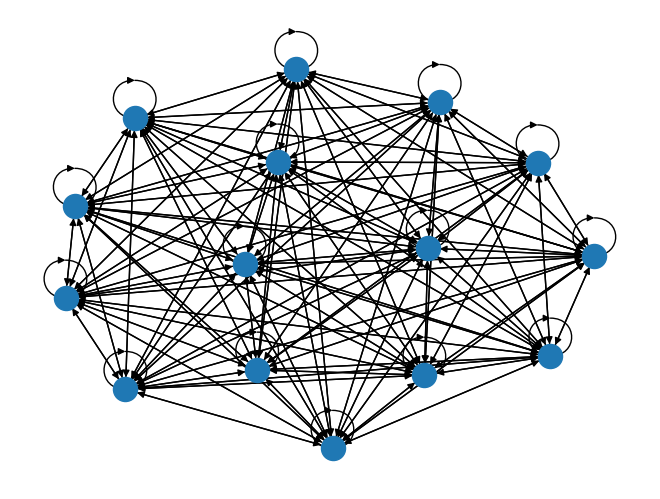

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                          | Type             | Params
--------------------------------------------------------------------
0  | model                         | GCN_Encoder      | 1.2 K 
1  | model.conv1                   | Custom_GCN       | 32

Epoch 19: 100%|██████████| 251/251 [00:09<00:00, 26.89it/s, loss=0.612, v_num=0, val_loss=0.621, val_auc=0.720, val_acc=0.665, learning_rate=1.56e-5, train_loss=0.622]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 251/251 [00:09<00:00, 26.76it/s, loss=0.612, v_num=0, val_loss=0.621, val_auc=0.720, val_acc=0.665, learning_rate=1.56e-5, train_loss=0.622]


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/graph_image_pl_15/version_0/checkpoints/epoch=19-step=3760-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/graph_image_pl_15/version_0/checkpoints/epoch=19-step=3760-v2.ckpt


Testing DataLoader 0: 100%|██████████| 63/63 [00:01<00:00, 38.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6710000038146973     │
│         test_auc          │    0.7127267122268677     │
└───────────────────────────┴───────────────────────────┘

In [76]:
class TopKIntensity(T.BaseTransform):
    def __init__(self, k: int):
        self.k = k
    
    def __call__(self, data):
        if data.num_nodes > self.k:
            _, top_k_indices = torch.topk(data.x[:, 0], self.k)
            data.x = data.x[top_k_indices]
            data.pos = data.pos[top_k_indices]
            data.num_nodes = self.k
        return data


class ToKTopIntensity(T.BaseTransform):
    def __init__(self, k: int):
        self.k = k
        
    def __call__(self, data):
        # Ensure data has enough nodes
        if data.num_nodes < self.k:
            raise ValueError("The graph has fewer nodes than k.")
        
        # Get indices of the k highest intensity nodes
        _, top_k_indices = torch.topk(data.x[:, 0], self.k)
        
        data.x = data.x[top_k_indices]
        data.pos = data.pos[top_k_indices]
        data.num_nodes = self.k
    
        # Use the node with the highest intensity for creating edges
        top_index = top_k_indices[0].item()
        
        # Create edges from all other nodes to the highest intensity node
        edges = []
        for i in range(data.num_nodes):
            if i != top_index:
                edges.append([i, top_index])
        
        # Convert edges to tensor
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        data.edge_index = edge_index
        
        return data



class KNNGroup(T.BaseTransform):
    def __init__(self, k: int, attr_name: str):
        self.k = k
        self.attr_name = attr_name

    def __call__(self, data, self_loop=True):
        if hasattr(data, self.attr_name):
            attr = getattr(data, self.attr_name)
            edge_index = pyg_nn.knn_graph(attr, k=self.k)
            data.edge_index = edge_index
            
            if self_loop:
                # Create self-loops
                num_nodes = attr.size(0)
                self_loops = torch.arange(0, num_nodes, dtype=torch.long).unsqueeze(0).repeat(2, 1)
                
                # Concatenate self-loops to edge_index
                edge_index = torch.cat([edge_index, self_loops], dim=1)
                data.edge_index = edge_index
        else:
            raise ValueError(f"Attribute '{self.attr_name}' not found in data.")
        return data

total_size = 10000
dataset = dataset[:total_size]

train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = int(0.2 * total_size)

batch_size = 32

k = 15

dataset.transform = T.Compose([TopKIntensity(k=k), KNNGroup(k=15, attr_name='x')])
sample = dataset[10]
print(sample)

print(f'Node degree: {sample.num_edges / sample.num_nodes:.2f}')
print(f'Has isolated nodes: {sample.has_isolated_nodes()}')
print(f'Has self-loops: {sample.has_self_loops()}')
print(f'Is undirected: {sample.is_undirected()}')
nx.draw(pyg.utils.to_networkx(dataset[10]))
plt.show()

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size, num_workers = 4)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size, num_workers = 4)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size, num_workers = 4)

GCN_encoder = GCN_Encoder()

Graph_pl = ModelPL_Classify(model=GCN_encoder, learning_rate=0.001)

logger = pl.loggers.CSVLogger(save_dir='logs', name=f'graph_image_pl_{k}', version=0)

summary_callback = pl.callbacks.ModelSummary(max_depth=8)
callbacks = [summary_callback]

# embeddings, labels = generate_embeddings(Contrastive_Graph_pl, val_loader)
# pca_proj(embeddings, labels)
# tsne_proj(embeddings, labels)
# vmf_kde_on_circle(embeddings, labels)

trainer_dynGCNN = pl.Trainer(max_epochs=20, 
                            accelerator='gpu',
                            callbacks=callbacks,
                            logger=logger,)

train_result = trainer_dynGCNN.fit(Graph_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_dynGCNN.test(dataloaders=test_loader)

/tmp/ipykernel_69534/2821880208.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


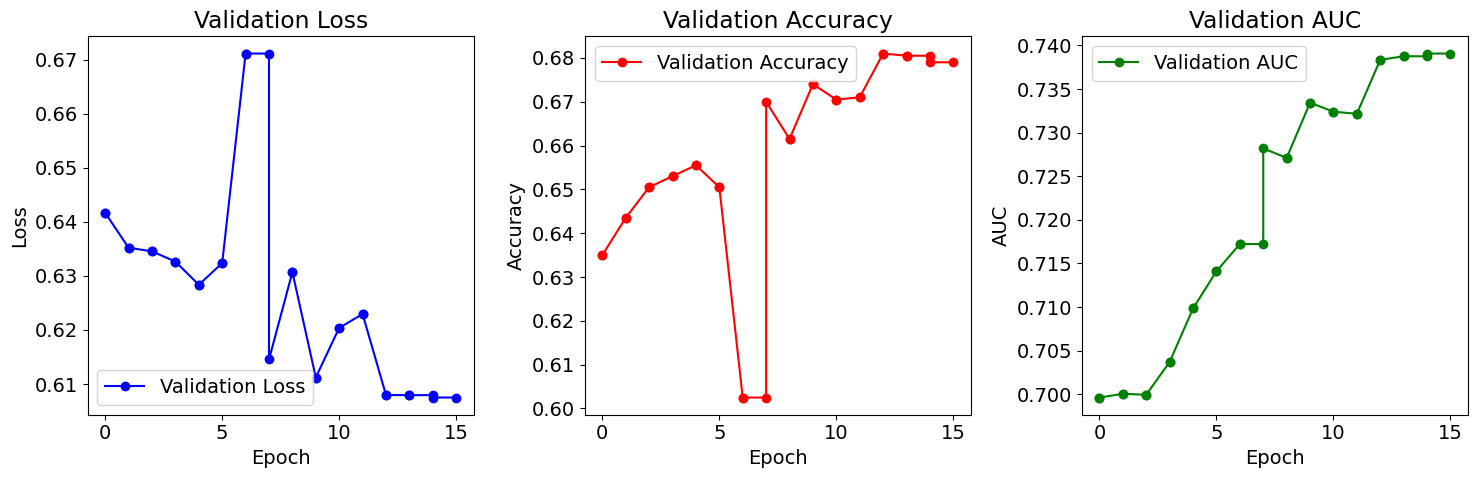

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics_from_csv(metrics_file):
    df = pd.read_csv(metrics_file)

    required_columns = {'epoch', 'val_loss', 'val_acc', 'val_auc'}
    if not required_columns.issubset(df.columns):
        raise ValueError("The CSV file does not contain the required metrics.")

    df = df.sort_values('epoch')

    df = df.fillna(method='ffill')

    epochs = df['epoch']
    val_loss = df['val_loss']
    val_acc = df['val_acc']
    val_auc = df['val_auc']

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, val_loss, marker='o', linestyle='-', color='b', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, val_acc, marker='o', linestyle='-', color='r', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_auc, marker='o', linestyle='-', color='g', label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Validation AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()


metrics_file = 'logs/graph_image_pl_15/version_0/metrics.csv' 
plot_metrics_from_csv(metrics_file)

